# Testing Data Processing

## Define necessary variables

In [5]:
# Create a directory to save the files
save_dir = './../data/vietnam_cloud_data'
# List of selected years
years = ['2001', '2003', '2005', '2007', '2009', '2011', '2013', '2015', '2017', '2019', '2021', '2023']
# List of selected months
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
# List of selected days
days = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']
# Time intervals for every 2 hours
times = ['00:00', '02:00', '04:00', '06:00', '08:00', '10:00', '12:00', '14:00', '16:00', '18:00', '20:00', '22:00']
# North, West, South, East coordinates for Vietnam
vietnam_area = [23, 102, 8, 110]

## Pull data from cds api

Get the api keys and pull data from the [CDS Website](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview)
Be mindful of the data limit per request to split up downloads accordingly.

In [2]:
import os
import cdsapi

# Create the directory if it does not exist
os.makedirs(save_dir, exist_ok=True)

# Initialize the CDS API client
c = cdsapi.Client()

# Loop over each year and retrieve data
for year in years:
    c.retrieve(
        'reanalysis-era5-single-levels',
        {
            'product_type': 'reanalysis',
            'format': 'netcdf',
            'variable': [
                'total_cloud_cover', 'high_cloud_cover', 'medium_cloud_cover', 'low_cloud_cover',
                'total_column_cloud_ice_water', 'total_column_cloud_liquid_water'
            ],
            'year': year,
            'month': days,
            'day': days,
            'time': times,
            'area': vietnam_area,
        },
        os.path.join(save_dir, f'vietnam_cloud_data_{year}.nc')
    )

2024-07-09 13:20:21,554 INFO Welcome to the CDS
2024-07-09 13:20:21,555 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2024-07-09 13:20:21,999 INFO Request is completed
2024-07-09 13:20:22,000 INFO Downloading https://download-0020.copernicus-climate.eu/cache-compute-0020/cache/data1/adaptor.mars.internal-1720505098.097453-10932-6-88a61e33-6f73-485d-a78a-7e88ec15b3ad.nc to ./../data/vietnam_cloud_data\vietnam_cloud_data_2021.nc (100.9M)
2024-07-09 13:21:11,127 INFO Download rate 2.1M/s  
2024-07-09 13:21:11,911 INFO Welcome to the CDS
2024-07-09 13:21:11,912 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2024-07-09 13:21:12,373 INFO Request is queued
2024-07-09 13:21:13,763 INFO Request is running
2024-07-09 13:49:55,298 INFO Request is completed
2024-07-09 13:49:55,299 INFO Downloading https://download-0003-clone.copernicus-climate.eu/cache-compute-0003/cache/data5/adapt

## Preprocess downloaded data

### Combine data files

Combine all the separately downloaded file into one and load into panda dataframe.

In [2]:
import xarray as xr
import pandas as pd

years = ['2023']

# List of yearly files
yearly_files = [f'./../data/vietnam_cloud_data/vietnam_cloud_data_{year}.nc' for year in years]

# Load datasets and inspect their time coordinates
datasets = []
for file, year in zip(yearly_files, years):
    ds = xr.open_dataset(file)
    # Inspect the time coordinates
    print(f"Time coordinates for {year}: {ds['time'].values}")
    datasets.append(ds)

# Combine datasets
combined_ds = xr.concat(datasets, dim='time')

# Save the combined dataset if needed
combined_ds.to_netcdf('./../data/vietnam_cloud_data/vietnam_cloud_data_combined.nc')

# Print available variables
print(combined_ds.data_vars)

Time coordinates for 2023: ['2023-01-01T00:00:00.000000000' '2023-01-01T02:00:00.000000000'
 '2023-01-01T04:00:00.000000000' ... '2023-12-31T18:00:00.000000000'
 '2023-12-31T20:00:00.000000000' '2023-12-31T22:00:00.000000000']
Data variables:
    tcc      (time, latitude, longitude) float64 71MB 0.8234 0.9716 ... 0.9897
    hcc      (time, latitude, longitude) float64 71MB 0.0 0.0 ... 0.8556 0.9811
    mcc      (time, latitude, longitude) float64 71MB 0.6642 0.5365 ... 0.1711
    lcc      (time, latitude, longitude) float64 71MB 0.7969 0.9683 ... 0.1567
    tciw     (time, latitude, longitude) float64 71MB 0.00292 ... 0.001371
    tclw     (time, latitude, longitude) float64 71MB 0.2274 0.2354 ... 0.04199


Convert to datafram

In [10]:
# List of variables
variables = ['tcc', 'hcc', 'mcc', 'lcc', 'tciw', 'tclw']

# Convert to DataFrame
df = combined_ds[variables].to_dataframe().reset_index()

### Visualize data

In [9]:
print(df.count())

time         8816940
latitude     8816940
longitude    8816940
tcc          8816940
hcc          8816940
mcc          8816940
lcc          8816940
tciw         8816940
tclw         8816940
dtype: int64


This is will show which column is missing how many values compare to the rest of the dataset. Nothing = Good

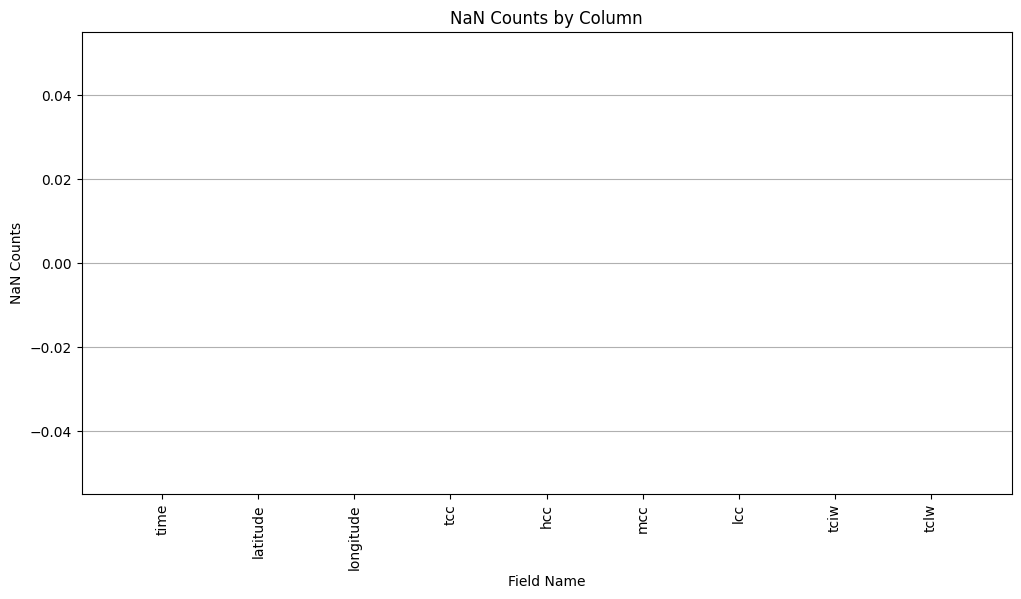

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_nan_counts(df):
    """
    Plots the number of NaN counts for each column in the dataset using Matplotlib.

    Parameters:
    df (pd.DataFrame): The dataset as a Pandas DataFrame.
    """
    # Calculate NaN counts
    nan_counts = df.isna().sum().sort_values(ascending=False).to_frame()
    nan_counts = nan_counts.reset_index()
    nan_counts.columns = ["Field Name", "NaN Counts"]

    # Plot NaN counts
    plt.figure(figsize=(12, 6))
    plt.bar(nan_counts["Field Name"], nan_counts["NaN Counts"], color='skyblue')
    plt.xticks(rotation=90)
    plt.xlabel("Field Name")
    plt.ylabel("NaN Counts")
    plt.title("NaN Counts by Column")
    plt.grid(axis='y')
    plt.show()
    
plot_nan_counts(df)

In [11]:
# Process the DataFrame to handle missing values, etc.
df = df.dropna()

# # Convert timestamps to a datetime format
df['time'] = pd.to_datetime(df['time'])

# Print the count of non-missing values in each column
print(df.count())

# Visualize data in the DataFrame
print(df.head())

# Save the DataFrame to a CSV file for easier inspection if needed
# df.to_csv('./../data/vietnam_cloud_data_2023.csv', index=False)

time         8816940
latitude     8816940
longitude    8816940
tcc          8816940
hcc          8816940
mcc          8816940
lcc          8816940
tciw         8816940
tclw         8816940
dtype: int64
        time  latitude  longitude       tcc  hcc       mcc       lcc  \
0 2023-01-01      23.0     102.00  0.823432  0.0  0.664184  0.796850   
1 2023-01-01      23.0     102.25  0.971617  0.0  0.536493  0.968291   
2 2023-01-01      23.0     102.50  0.954435  0.0  0.358155  0.947935   
3 2023-01-01      23.0     102.75  0.977752  0.0  0.214899  0.974578   
4 2023-01-01      23.0     103.00  1.000000  0.0  0.111242  1.000000   

       tciw      tclw  
0  0.002920  0.227390  
1  0.001609  0.235440  
2  0.000775  0.302221  
3  0.000536  0.256048  
4  0.000179  0.073800  


Visualizing data count by hours

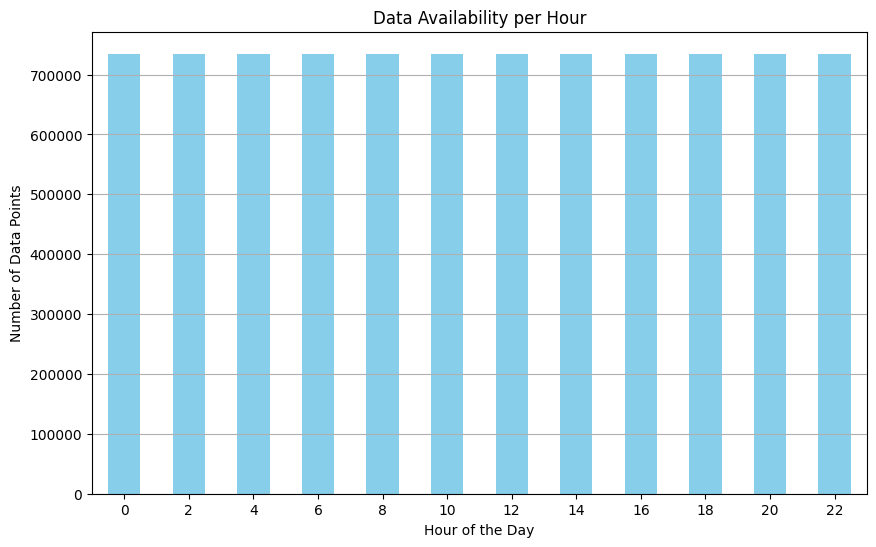

In [8]:
def plot_data_availability_per_hour(df, time_column='time', title="Data Availability per Hour"):
    """
    Plots the total number of data points available per hour in the dataset.

    Parameters:
    df (pd.DataFrame): The dataset as a Pandas DataFrame.
    time_column (str): The name of the column containing the datetime information.
    title (str): The title of the plot.
    """
    # Ensure the time column is in datetime format
    df[time_column] = pd.to_datetime(df[time_column])
    
    # Extract the hour from the datetime column
    df['hour'] = df[time_column].dt.hour
    
    # Group by hour and count the number of records for each hour
    hourly_counts = df.groupby('hour').size()
    
    # Plot the data
    plt.figure(figsize=(10, 6))
    hourly_counts.plot(kind='bar', color='skyblue')
    plt.title(title)
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Data Points')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.show()
    
plot_data_availability_per_hour(df)

See total cloud over at a specific (lat, long) loocation of 2023

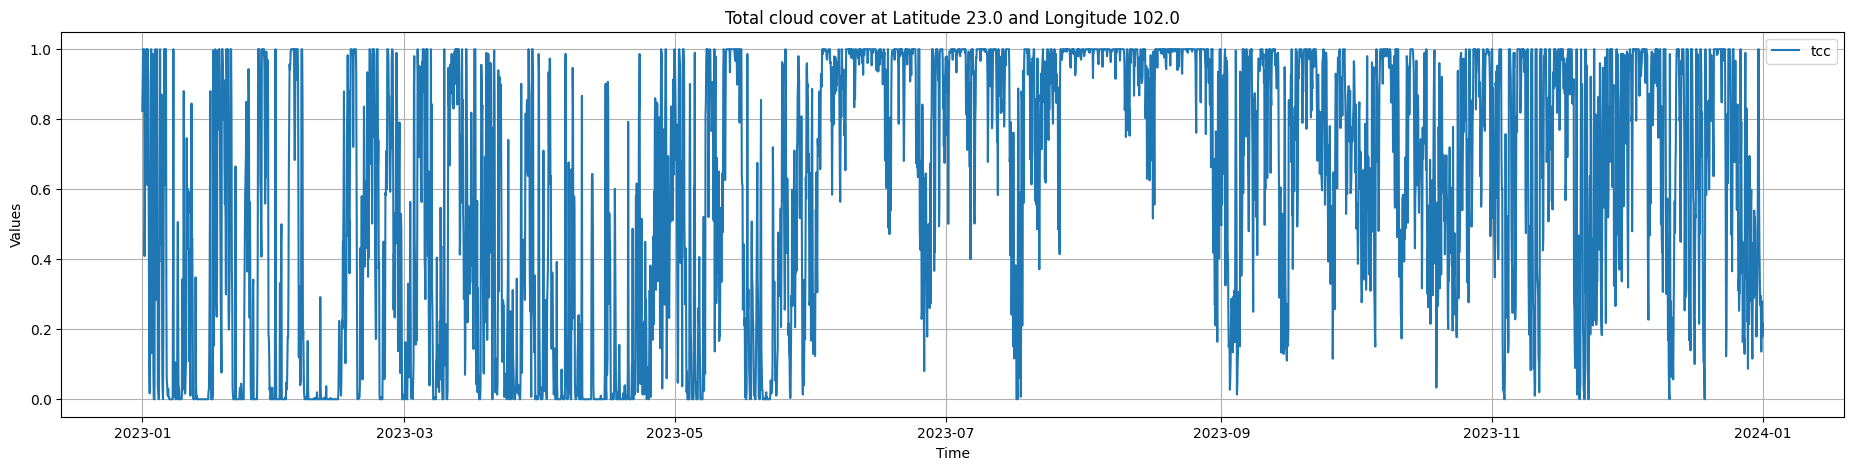

In [17]:
import seaborn as sns

# Filter the DataFrame for a specific latitude and longitude
latitude = 23.0
longitude = 102.0
filtered_df = df[(df['latitude'] == latitude) & (df['longitude'] == longitude)]

# Plot the time series for the variables of interest
# variables = ['tcc', 'hcc', 'mcc', 'lcc', 'tciw', 'tclw']
variables = ['tcc']


plt.figure(figsize=(23, 5))
for var in variables:
    sns.lineplot(data=filtered_df, x='time', y=var, label=var)

plt.title(f'Total cloud cover at Latitude {latitude} and Longitude {longitude}')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

## Preprocessing

### Create Lag Column for Training

In [21]:
def create_lag_features(df, column, lags):
    for lag in lags:
        df[f"{column}_lag{lag}"] = df[column].shift(lag)
    return df

# Create lag features for each variable
for var in variables:
    df = create_lag_features(df, var, lags=[2, 4, 6])  # Example lags: 2, 4, 6 hours
df = df.dropna()  # Drop rows with NaN values resulting from lag creation

In [23]:
print(df.head())
print(df.count())

         time  latitude  longitude       tcc  hcc       mcc       lcc  \
6  2023-01-01      23.0     103.50  1.000000  0.0  0.103154  1.000000   
7  2023-01-01      23.0     103.75  0.729465  0.0  0.122839  0.704866   
8  2023-01-01      23.0     104.00  0.993408  0.0  0.096593  0.993408   
9  2023-01-01      23.0     104.25  0.994995  0.0  0.095463  0.994995   
10 2023-01-01      23.0     104.50  1.000000  0.0  0.080479  1.000000   

        tciw      tclw  tcc_lag2  ...  mcc_lag6  lcc_lag2  lcc_lag4  lcc_lag6  \
6   0.000179  0.214640  1.000000  ...  0.664184  1.000000  0.947935  0.796850   
7   0.000238  0.155458  1.000000  ...  0.536493  1.000000  0.974578  0.968291   
8   0.000179  0.077600  1.000000  ...  0.358155  1.000000  1.000000  0.947935   
9   0.000238  0.097821  0.729465  ...  0.214899  0.704866  1.000000  0.974578   
10  0.000179  0.139100  0.993408  ...  0.111242  0.993408  1.000000  1.000000   

    tciw_lag2  tciw_lag4  tciw_lag6  tclw_lag2  tclw_lag4  tclw_lag6  
6  

### Normalize and Scale the Data

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_columns = variables + [f"{var}_lag{lag}" for var in variables for lag in [1, 2, 3]]
df[scaled_columns] = scaler.fit_transform(df[scaled_columns])


### Split up data for training

Split data into train (0.7), test (0.15), val (0.15)

In [11]:
from sklearn.model_selection import train_test_split

train_size = 0.7
val_size = 0.15
test_size = 0.15

train_df, temp_df = train_test_split(df, train_size=train_size, shuffle=False)
val_df, test_df = train_test_split(temp_df, test_size=test_size/(val_size+test_size), shuffle=False)
